# GAN

*generative adversarial networks* (敵対的生成ネットワーク)

<br>

GANをpytorchで実装する

とりあえずMNIST


---

## 必要なもの

### ライブラリ

In [37]:
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### MNISTデータセット

In [38]:
from torchvision.datasets import MNIST
from torchvision import transforms

mnist = MNIST(
    root='./data',
    train=False,
    transform=transforms.ToTensor(),
    download=True)

X = mnist.data.reshape(-1, 28*28).to(device) / 255
X = X[:1000]
X.shape

torch.Size([1000, 784])


---

## generator

生成機

ノイズ(10次元ベクトル)から784次元のベクトルを生成する。  
出力値は各ピクセルの濃淡を $0 \sim 1$ で表すので`sigmoid`関数をかける。

In [39]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(100, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid()
        )

    def forward(self, n):
        noises = torch.randn(n, 100).to(device)
        return self.network(noises)


---

## discriminator

識別器。偽物である確率を出力する。

In [40]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)


---

## 学習



### discriminator

識別器の学習

In [41]:
def train_disc(model, data_loader, optimizer):
    model.train()
    for img, label in data_loader:
        optimizer.zero_grad()
        y = model(img)
        loss = F.mse_loss(label, y)
        loss.backward(retain_graph=True)
        optimizer.step()

### generator

生成機の学習。誤差は出力画像を識別器にかけた値(偽物である確率)。

In [42]:
def train_gen(model, discriminator, optimizer, batch_size):
    model.train()
    optimizer.zero_grad()
    img = model(batch_size) # 画像を生成
    loss = discriminator(img).mean() # 偽物である確率を計算
    loss.backward(retain_graph=True)
    optimizer.step()
    return img

### 敵対

二つを学習させる

#### dataset

MNISTの手書き数字のデータと生成機で生成したデータを結合したdataset(DataLoader)を作る


データ | ラベル | 
--- | --- |
手書き数字1 | 0
手書き数字2 | 0
手書き数字3 | 0
: | : |
生成した画像1 | 1
生成した画像2 | 1
生成した画像3 | 1
: | :


In [43]:
def make_dataloader(generator, X, batch_size):
    # データ数の取得
    n_samples = X.shape[0]

    # 同じ数だけ画像を生成
    img = generator(n_samples)

    # 結合
    images = torch.cat((X, img))

    # ラベル作成
    zeros = torch.zeros(n_samples)
    ones = torch.ones(n_samples)
    labels = torch.cat((zeros, ones)).reshape(-1, 1).to(device)

    # dataloader作成
    dataset = TensorDataset(images, labels)
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True)

    return data_loader

In [44]:
def train(epochs, generator, discriminator, X, batch_size):
    history = generator(128)
    for epoch in range(epochs):
        print(f'\r{epoch + 1:>3} epoch', end='')
        data_loader = make_dataloader(generator, X, batch_size)
        train_disc(discriminator, data_loader, disc_optim)
        for _ in range((len(X) // batch_size) + 1):
            y = train_gen(generator, discriminator, gen_optim, batch_size)
            history = torch.cat((history, y))
    return history

In [45]:
def images_plot(images, n=5, size=2):
    plt.figure(figsize=(size * n, size))
    idx = torch.linspace(0, len(images) - 1, n).to(int)
    for i, img in enumerate(images[idx].cpu()):
        plt.subplot(1, n, i + 1)
        plt.imshow(img.reshape(28, 28).detach().numpy(), cmap='gray')
    plt.tight_layout()

In [46]:
generator = Generator()
discriminator = Discriminator()

gen_optim = optim.Adam(generator.parameters(), lr=0.001)
disc_optim = optim.Adam(discriminator.parameters(), lr=0.001)

generator.to(device)
discriminator.to(device);

In [47]:
images = train(5, generator, discriminator, X, 128)

  5 epoch

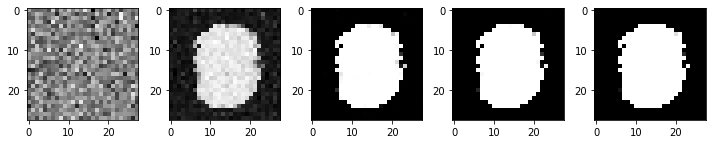

In [48]:
images_plot(images)

うまくいってなさそう


---

## 識別器を改良

確率を見てみる

In [49]:
print('MNIST', discriminator(X[0]).item())
print('初期値での生成画像', discriminator(images[0]).item())
print('5epoch終了時の生成画像', discriminator(images[-1]).item())

MNIST 7.715297215327155e-06
初期値での生成画像 0.9999659061431885
5epoch終了時の生成画像 9.582235103121516e-22


生成画像の方が本物より本物ということになっている

識別器をCNNにしてみる

In [50]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1568, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.reshape(-1, 1, 28, 28)
        return self.network(x)

In [51]:
generator = Generator()
discriminator = Discriminator()

gen_optim = optim.Adam(generator.parameters(), lr=0.001)
disc_optim = optim.Adam(discriminator.parameters(), lr=0.001)

generator.to(device)
discriminator.to(device);

In [52]:
images = train(5, generator, discriminator, X, 128)

  5 epoch

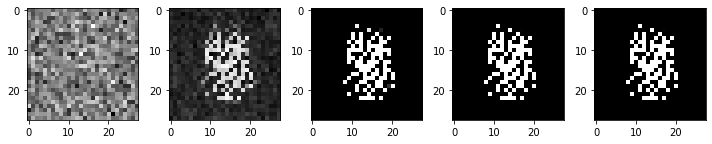

In [53]:
images_plot(images)

確率

In [54]:
print('MNIST', discriminator(X[0]).item())
print('初期値での生成画像', discriminator(images[0]).item())
print('5epoch終了時の生成画像', discriminator(images[-1]).item())

MNIST 8.339563464687672e-06
初期値での生成画像 0.9999579191207886
5epoch終了時の生成画像 1.98297655629176e-07


やはり識別器が弱すぎる


---

## 生成器を改良する

生成器もいじってみる

参考サイトのものをコピペ

参考  
[pytorchでDCGANを作成しMNISTのフェイク画像を生成する - Qiita](https://qiita.com/miso_taku/items/a34f6b598d2c8988d18c)

In [55]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            self.conv_trans_layers(100, 512, 3, 1, 0),
            self.conv_trans_layers(512, 256, 3, 2, 0),
            self.conv_trans_layers(256, 128, 4, 2, 1),
            self.conv_trans_layers(128, 1, 4, 2, 1),
            nn.Flatten()
        )

    @staticmethod
    def conv_trans_layers(
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding
    ):
        net = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding), 
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        return net

    def forward(self, n_samples):
        noises = torch.randn(n_samples, 100, 1, 1)
        return self.network(noises)

In [56]:
generator = Generator()
discriminator = Discriminator()

gen_optim = optim.Adam(generator.parameters(), lr=0.001)
disc_optim = optim.Adam(discriminator.parameters(), lr=0.001)

generator.to(device)
discriminator.to(device);

In [57]:
images = train(5, generator, discriminator, X, 128)

  5 epoch

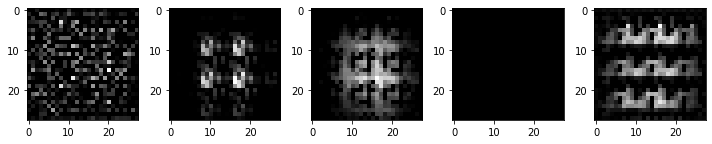

In [58]:
images_plot(images)

In [59]:
print('MNIST', discriminator(X[0]).item())
print('初期値での生成画像', discriminator(images[0]).item())
print('5epoch終了時の生成画像', discriminator(images[-1]).item())

MNIST 0.14025603234767914
初期値での生成画像 1.0
5epoch終了時の生成画像 0.4828181564807892



---

## BCEloss

In [36]:
def train_disc(model, data_loader, optimizer):
    model.train()
    for img, label in data_loader:
        optimizer.zero_grad()
        y = model(img)
        loss = F.binary_cross_entropy(y, label)
        loss.backward(retain_graph=True)
        optimizer.step()

In [85]:
def train_gen(model, discriminator, optimizer, batch_size):
    model.train()
    optimizer.zero_grad()
    img = model(batch_size) # 画像を生成

    prob = discriminator(img) # 偽物である確率を計算

    # 誤差を計算
    label = torch.zeros_like(prob)
    loss = F.binary_cross_entropy(prob, label)

    loss.backward(retain_graph=True)
    optimizer.step()
    return img

In [92]:
generator = Generator()
discriminator = Discriminator()

gen_optim = optim.Adam(generator.parameters(), lr=0.001)
disc_optim = optim.Adam(discriminator.parameters(), lr=0.001)

generator.to(device)
discriminator.to(device);

In [93]:
images = train(5, generator, discriminator, X, 128)

  5 epoch

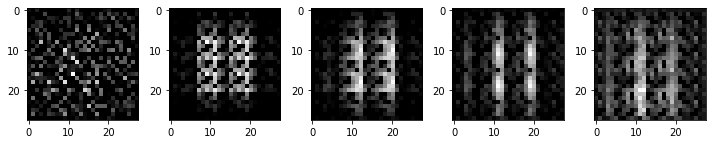

In [94]:
images_plot(images)

In [95]:
print('MNIST', discriminator(X[0]).item())
print('初期値での生成画像', discriminator(images[0]).item())
print('5epoch終了時の生成画像', discriminator(images[-1]).item())

MNIST 0.040928374975919724
初期値での生成画像 1.0
5epoch終了時の生成画像 0.16037048399448395


In [96]:
epochs = 1
batch_size = 128
for epoch in range(epochs):
    print(f'\r{epoch + 1:>3} epoch', end='')
    data_loader = make_dataloader(generator, X, batch_size)
    train_disc(discriminator, data_loader, disc_optim)

  1 epoch

In [97]:
print('MNIST', discriminator(X[0]).item())
print('初期値での生成画像', discriminator(images[0]).item())
print('5epoch終了時の生成画像', discriminator(images[-1]).item())

MNIST 0.030937571078538895
初期値での生成画像 0.9999998807907104
5epoch終了時の生成画像 0.8654884099960327
